In [ ]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN

# FIXMATCH
from fixmatch_DA import fixmatch_DA_train

# os
import os
import path

# sklearn - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%load_ext autoreload
%autoreload 2

In [2]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9
LAMBDA_U = 3
MU = 4
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [4]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49140504 0.48212692 0.44649363], std: [0.24635723 0.24281505 0.26072875]


In [6]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [8]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.10

# load indices
indices_10 = torch.load('../SPLITS/SPLIT_10.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_10)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [9]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [10]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='10_CORESET'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 27.41%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 33.43%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.51%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 35.32%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 32.83%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 42.14%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 44.43%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 46.93%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.17%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.08%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.48%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.75%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.62%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.7%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.36%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.27%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.84%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.83%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.87%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.13%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.27%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.07%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.8%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.12%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.23%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.61%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.67%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.51%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.73%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.4%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.74%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.39%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.74%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.56%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.64%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.78%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.8%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.64%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.17%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.68%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.47%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.25%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.1%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.26%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.15%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.73%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.63%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.93%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.48%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.78%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.26%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.79%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.56%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.48%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.84%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.15%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.37%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.08%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.28%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.34%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.59%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.12%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.44%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.73%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.55%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.11%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.51%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.23%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.07%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.07%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.76%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.66%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.12%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.85%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.26%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.02%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.61%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.72%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.93%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.82%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.06%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.59%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.5%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.06%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.91%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.5%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.31%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.71%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.63%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.32%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.62%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.62%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.39%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.96%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.85%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.92%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.08%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.06%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.18%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.46%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.35%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.68%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.09%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.93%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.17%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.65%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.04%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.45%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.51%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.91%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.05%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.08%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.3%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.91%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.36%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.95%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.67%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.22%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.96%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.16%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.54%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.61%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.89%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.65%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.27%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.75%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.94%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.58%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.49%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.72%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.7%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.94%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.3%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.26%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.73%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.36%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.77%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.99%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.53%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.05%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.79%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.42%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.16%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.92%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.44%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.08%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.48%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.25%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.22%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.19%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.1%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.23%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.34%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.35%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.79%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.73%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.95%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.03%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.88%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.93%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.67%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.51%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.25%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.75%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.66%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.28%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.76%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.23%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.18%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.38%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.39%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.34%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.78%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.99%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.89%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.38%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.72%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.64%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.01%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.46%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.27%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.89%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.62%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.81%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.6%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.03%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.93%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.12%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.9%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.26%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.59%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.4%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.37%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.25%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.35%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.75%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.57%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.37%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.42%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.45%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.19%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.95%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.45%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.72%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.29%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.9%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.17%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.9%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.13%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.76%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.76%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.68%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.84%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.1%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.51%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.97%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.76%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.84%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.13%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.22%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.8%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.18%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.17%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.61%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.24%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.98%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.77%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.03%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.75%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.75%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.19%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.23%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.6%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.22%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.59%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.45%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.49%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.3%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.51%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.68%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.26%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.3%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.6%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.39%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.42%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.36%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.48%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.68%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.57%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.32%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.38%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.65%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.8%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.56%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.57%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.69%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.68%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.59%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.49%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.68%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.54%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.59%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.57%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.59%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.65%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.79%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.65%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.7%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.69%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.71%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.71%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.72%
Finished Training


In [15]:
# open results
model_10 = ConvNN().to(device)
model_10.load_state_dict(torch.load('./results/models/model_DA_10_CORESET.pth'))
train_losses_10 = torch.load('./results/metrics/train_losses_DA_10_CORESET.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_DA_10_CORESET.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_DA_10_CORESET.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_DA_10_CORESET.pth')

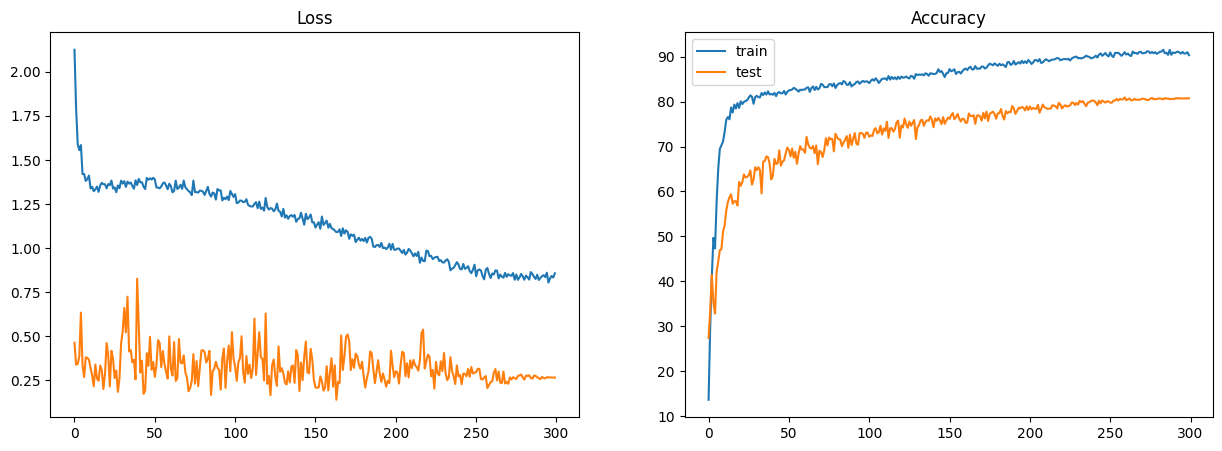

In [16]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_10_CORESET.png")

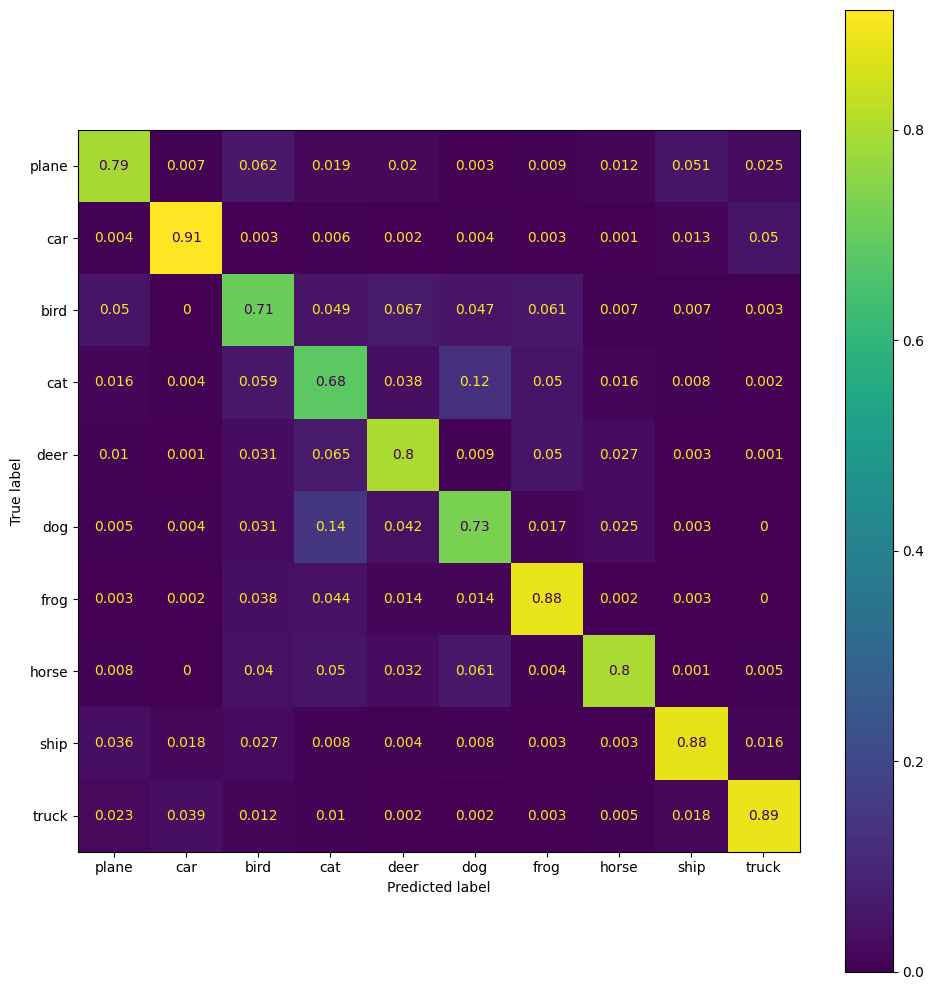

In [17]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_10_CORESET.png")

Test Accuracy: 80.72%


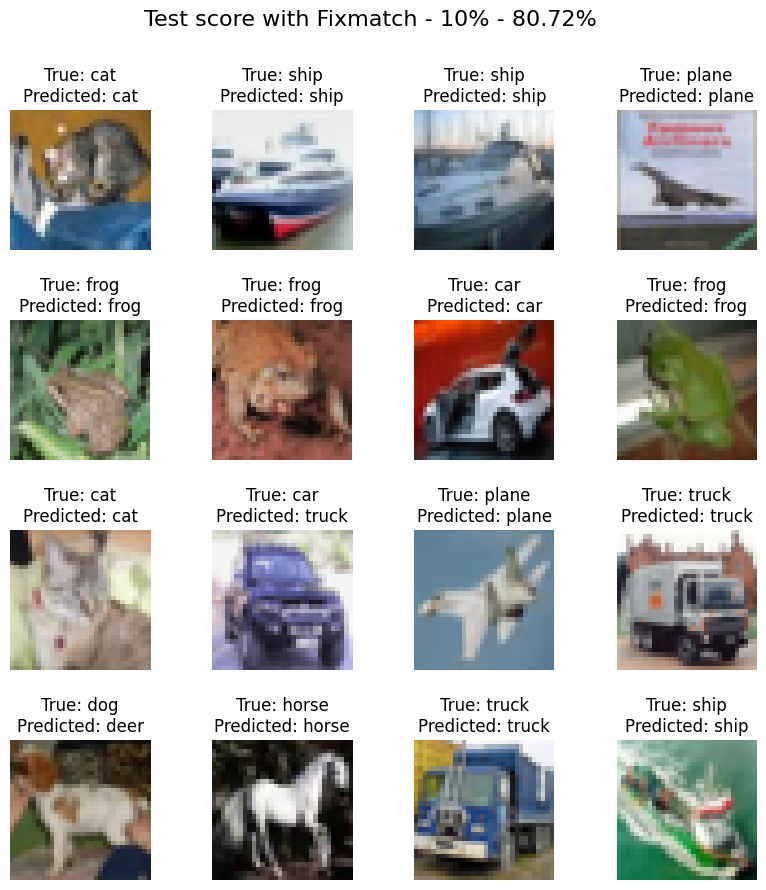

In [18]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_10(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_10_CORESET.png")

### III.2 Fixmatch on 5% train data

In [8]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.05

# load indices
indices_05 = torch.load('../SPLITS/SPLIT_05.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_05)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/home/europe/miniconda3/envs/pytorch-tabular/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [9]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [10]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='05_CORESET'
)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.1%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 28.88%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.62%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
# open results
model_05 = ConvNN().to(device)
model_05.load_state_dict(torch.load('./results/models/model_DA_05_CORESET.pth'))
train_losses_05 = torch.load('./results/metrics/train_losses_DA_05_CORESET.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_DA_05_CORESET.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_DA_05_CORESET.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_DA_05_CORESET.pth')

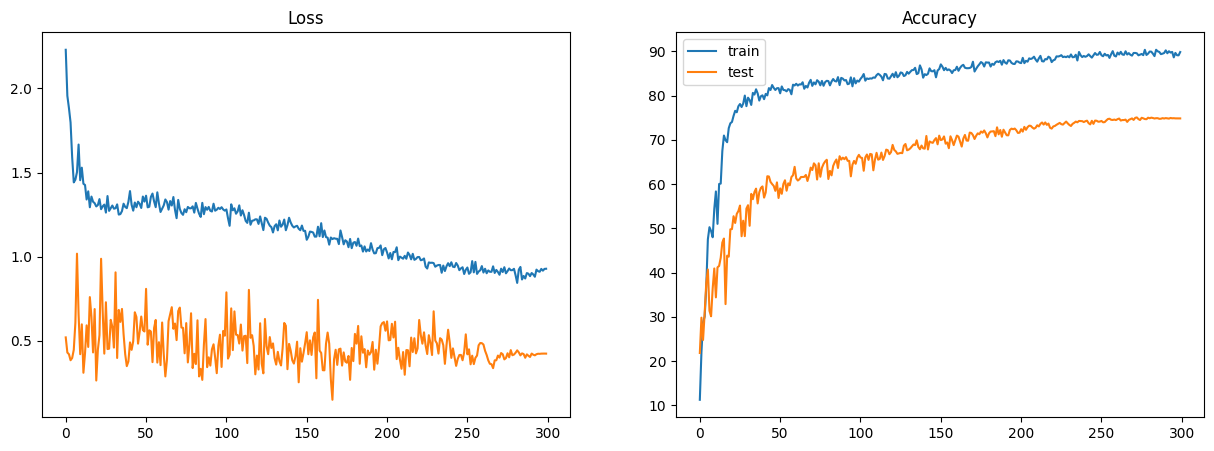

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_05_CORESET.png")

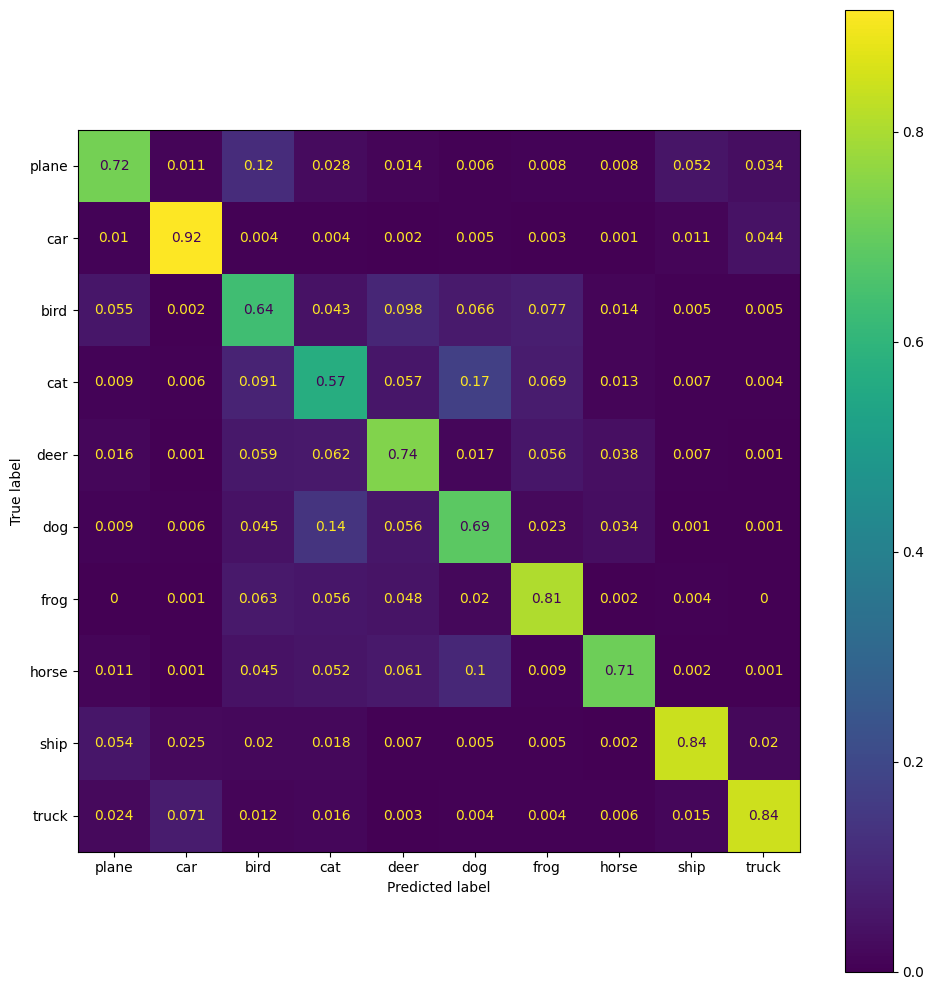

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_05_CORESET.png")

Test Accuracy: 74.83%


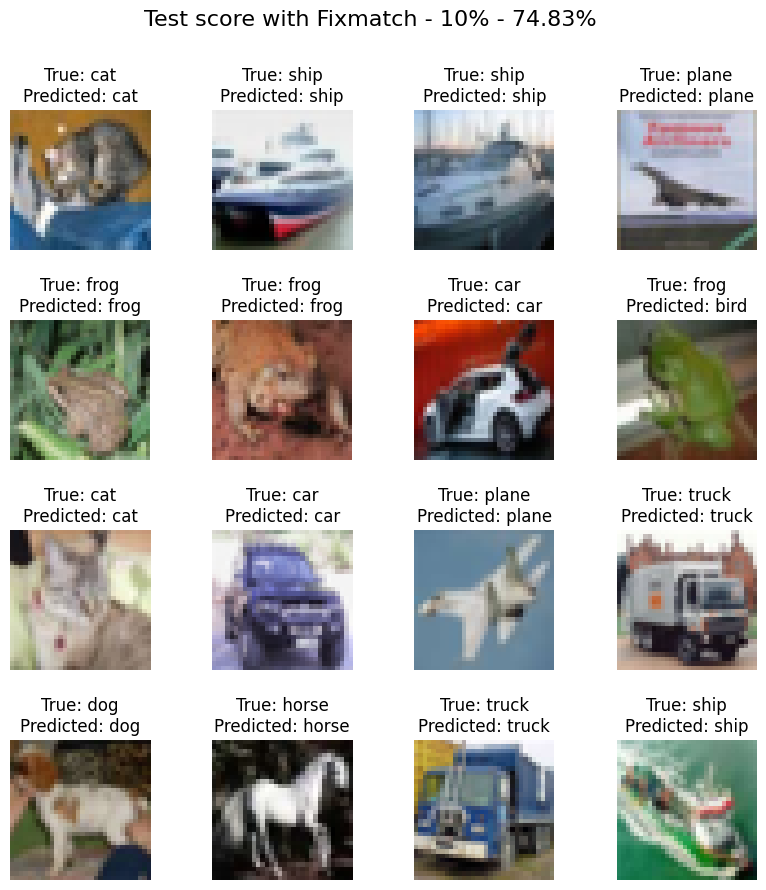

In [ ]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_05(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_05_CORESET.png")

### III.3 Fixmatch on 1% train data

In [22]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.01

# load indices
indices_01 = torch.load('../SPLITS/SPLIT_01.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_01)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/home/europe/miniconda3/envs/pytorch-tabular/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [23]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [24]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='01_CORESET'
)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.05%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.39%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.62%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 18.68%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 15.72%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 24.51%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.02%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.46%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.87%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.62%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.67%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.1%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.74%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.44%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.23%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.49%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.77%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.91%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.02%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.91%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.05%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.4%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.22%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.79%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.56%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.35%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.13%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.05%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.93%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.0%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.09%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.07%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.65%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.44%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.82%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.21%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.88%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.02%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.61%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.99%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.66%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.34%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.88%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.79%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.51%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.79%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.69%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.14%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.51%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.04%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.86%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.02%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.23%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.8%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.29%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.28%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.62%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.81%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.71%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.51%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.66%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.53%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.73%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.31%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.96%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.97%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.8%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.51%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.59%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.36%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.4%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.38%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.26%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.92%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.5%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.15%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.25%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.69%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.62%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.26%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.66%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.27%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.62%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.36%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.59%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.88%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.56%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.87%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.9%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.82%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.67%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.28%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.79%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.41%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.58%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.94%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.23%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.64%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.14%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.13%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.92%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.46%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.99%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.18%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.19%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.46%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.98%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.36%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.19%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.54%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.15%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.54%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.68%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.57%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.59%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.13%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.92%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.9%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.24%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.98%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.56%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.07%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.82%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.33%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.5%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.05%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.13%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.9%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.38%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.82%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.96%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.51%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.28%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.98%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.44%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.09%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.25%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.13%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.47%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.6%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.99%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.62%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.95%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.83%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.6%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.68%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.23%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.3%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.8%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.14%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.29%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.52%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.17%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.19%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.92%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.15%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.73%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.62%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.12%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.2%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.06%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.72%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.63%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.72%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.03%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.71%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.19%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.63%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.58%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.53%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.85%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.96%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.79%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.01%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.65%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.59%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.98%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.92%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.22%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.7%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.43%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.84%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.63%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.18%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.34%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.79%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.49%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.54%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.57%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.92%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.24%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.02%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.69%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.08%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.46%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.15%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.3%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.39%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.08%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.85%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.2%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.92%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.64%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.74%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.62%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.9%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.3%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.78%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.81%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.04%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.2%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.43%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.33%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.91%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.19%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.66%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.09%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.37%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.54%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.82%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.2%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.65%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.5%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.21%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.98%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.33%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.76%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.43%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.02%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.92%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.37%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.43%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.67%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.54%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.91%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.87%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.95%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.21%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.66%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.57%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.83%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.03%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.57%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.71%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.73%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.72%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.49%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.86%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.62%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.82%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 54.03%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.98%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.41%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.07%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.33%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.35%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.74%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.38%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.8%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.19%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.19%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.04%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.05%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.21%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.2%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.45%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.54%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.56%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.5%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.6%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.91%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.68%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.71%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.71%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.75%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.63%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.64%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.74%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.83%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.84%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.79%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.71%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.64%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.68%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.6%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.61%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.59%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.54%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.51%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.47%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.5%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.51%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 53.56%
Finished Training


In [25]:
# open results
model_01 = ConvNN().to(device)
model_01.load_state_dict(torch.load('./results/models/model_DA_01_CORESET.pth'))
train_losses_01 = torch.load('./results/metrics/train_losses_DA_01_CORESET.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_DA_01_CORESET.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_DA_01_CORESET.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_DA_01_CORESET.pth')

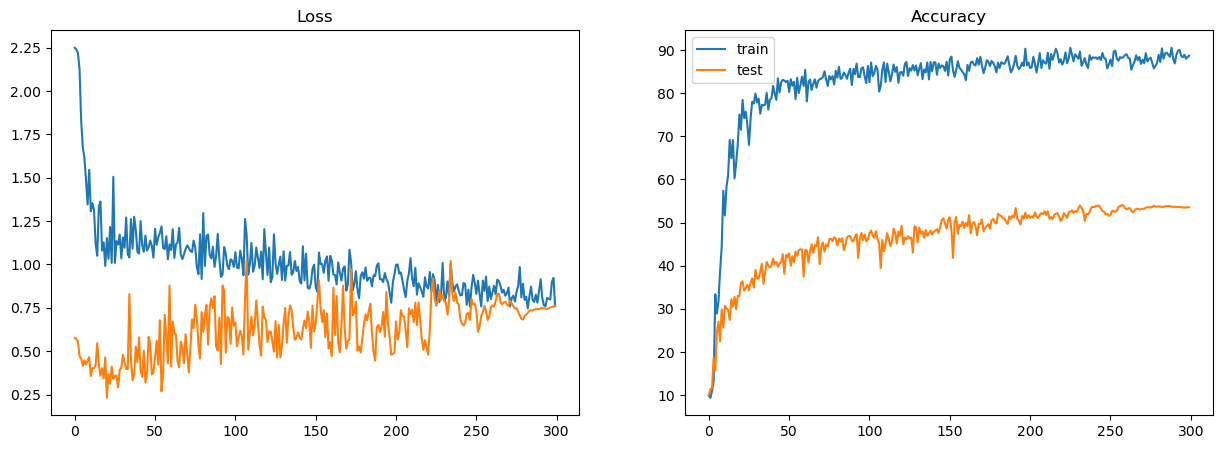

In [26]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_01_CORESET.png")

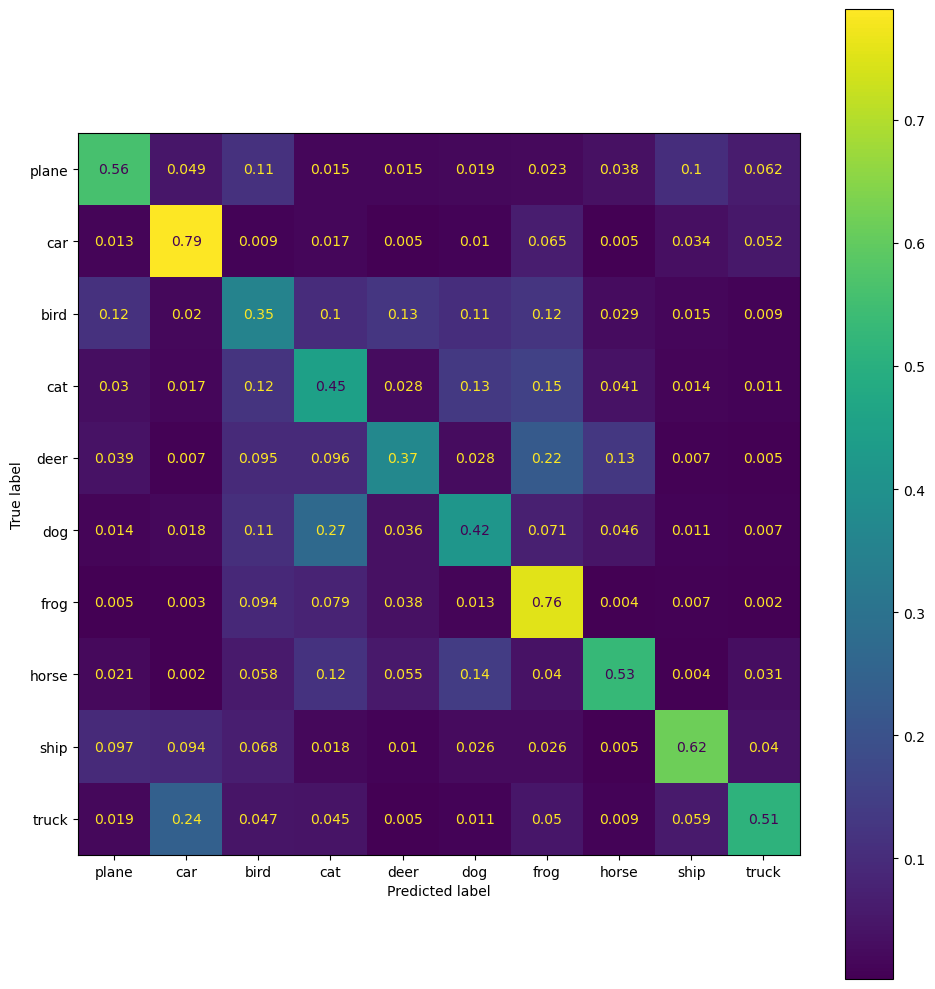

In [27]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_01_CORESET.png")

Test Accuracy: 53.56%


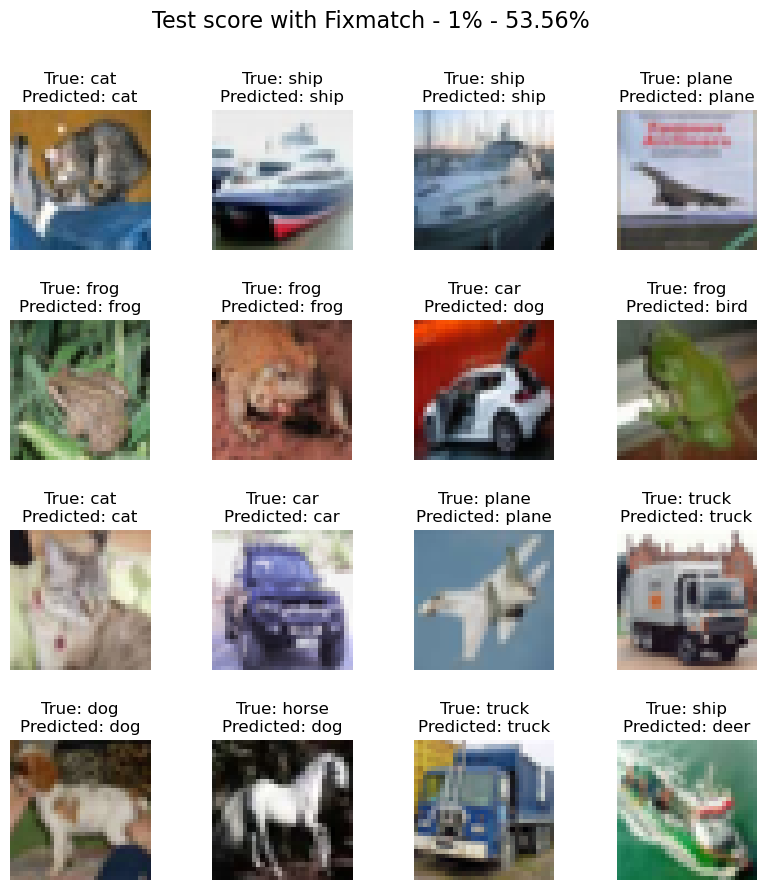

In [28]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_01(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_01_CORESET.png")